<a href="https://colab.research.google.com/github/Chandravardhan02/Ecommerce_Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

end to end

In [18]:
!pip install -q textblob nltk wordcloud transformers torch seaborn scikit-learn


Dataset shape: (110, 8)
sentiment
positive    53
negative    41
neutral     16
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

    negative       0.50      0.14      0.22         7
     neutral       0.00      0.00      0.00         3
    positive       0.60      1.00      0.75        12

    accuracy                           0.59        22
   macro avg       0.37      0.38      0.32        22
weighted avg       0.49      0.59      0.48        22



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


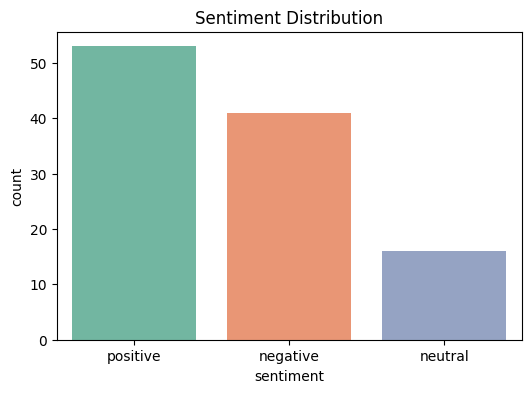


 Top 5 Products:
                  product_name  avg_rating  review_count  positive_reviews  \
3      FlexFit Running Tights    4.166667            12                 9   
9  The Silent Observer (Book)    3.727273            11                 6   
2       Aura X-Pro Smartphone    3.454545            11                 5   
7  PowerLink Portable Charger    3.400000            10                 5   
5       Hercules Dumbbell Set    3.363636            11                 6   

   negative_reviews  
3                 2  
9                 2  
2                 3  
7                 4  
5                 4  

 Bottom 5 Products:
                product_name  avg_rating  review_count  positive_reviews  \
1  All-Weather Hiking Boots    2.200000            10                 2   
6    Organic Valley Cashews    2.909091            11                 5   
8        Radiant Glow Serum    3.090909            11                 4   
4   Geo-Woven Throw Blanket    3.166667            12           

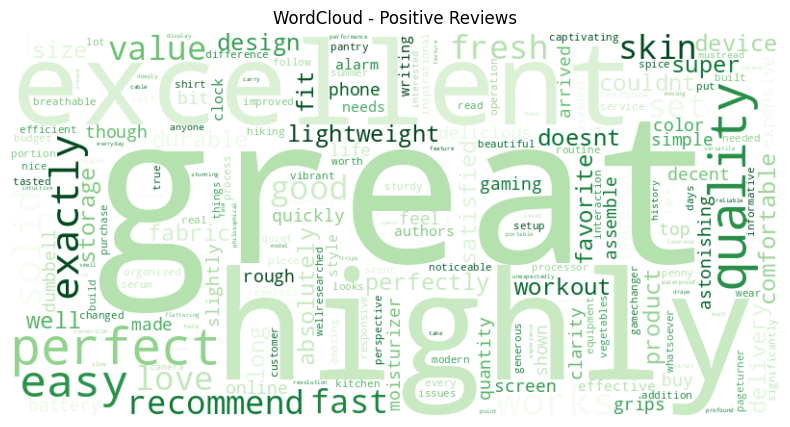

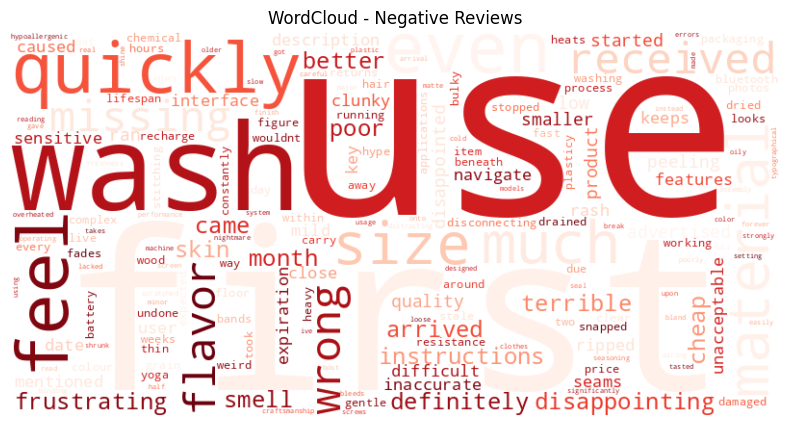

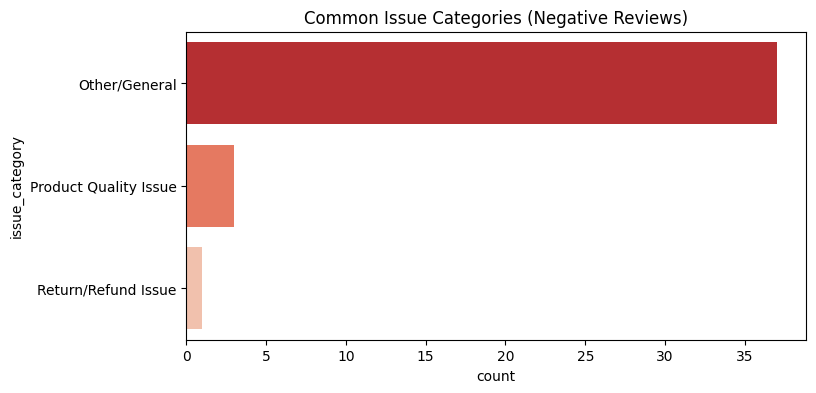


Issue Summary:
           issue_category  count
0          Other/General     37
1  Product Quality Issue      3
2    Return/Refund Issue      1

 Recommendations for Improvement:
-  Product 'All-Weather Hiking Boots' has low average rating (2.20). Top issues: Other/General, Return/Refund Issue. Suggest investigating Other/General first.
-  Product 'Organic Valley Cashews' has low average rating (2.91). Top issues: Other/General, Product Quality Issue. Suggest investigating Other/General first.
-  Product 'Radiant Glow Serum' has low average rating (3.09). Top issues: Other/General. Suggest investigating Other/General first.
-  Product 'Geo-Woven Throw Blanket' has low average rating (3.17). Top issues: Other/General. Suggest investigating Other/General first.
-  Product 'Hercules Dumbbell Set' has low average rating (3.36). Top issues: Other/General. Suggest investigating Other/General first.

  Sentiment Analysis Completed!
Files saved in files 


In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline
nltk.download('stopwords')


df = pd.read_csv("/content/ecommerce_data.csv")

df['review_text'] = df['review_text'].astype(str).str.lower()
df.dropna(subset=['review_text'], inplace=True)

def label_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment'] = df['rating'].apply(label_sentiment)

print("Dataset shape:", df.shape)
print(df['sentiment'].value_counts())
stop = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = " ".join([w for w in text.split() if w not in stop and len(w) > 2])
    return text

df['clean_text'] = df['review_text'].apply(clean_text)
df['textblob_polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X = df['clean_text']
y = df['sentiment']

tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_vec = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.show()

product_summary = df.groupby('product_name').agg(
    avg_rating=('rating', 'mean'),
    review_count=('rating', 'count'),
    positive_reviews=('sentiment', lambda x: (x=='positive').sum()),
    negative_reviews=('sentiment', lambda x: (x=='negative').sum())
).reset_index()

top_products = product_summary.sort_values('avg_rating', ascending=False).head(5)
worst_products = product_summary.sort_values('avg_rating').head(5)

print("\n Top 5 Products:\n", top_products)
print("\n Bottom 5 Products:\n", worst_products)

for sentiment in ['positive', 'negative']:
    text = " ".join(df[df['sentiment'] == sentiment]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens' if sentiment=='positive' else 'Reds').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {sentiment.title()} Reviews")
    plt.show()

def issue_category(text):
    text = text.lower()
    if any(word in text for word in ['late', 'delay', 'delivery', 'shipping']):
        return 'Delivery Issue'
    elif any(word in text for word in ['broken', 'defect', 'quality', 'damage', 'faulty']):
        return 'Product Quality Issue'
    elif any(word in text for word in ['package', 'packing', 'box', 'seal']):
        return 'Packaging Issue'
    elif any(word in text for word in ['refund', 'return', 'exchange', 'replace']):
        return 'Return/Refund Issue'
    elif any(word in text for word in ['support', 'service', 'help', 'response']):
        return 'Customer Service Issue'
    else:
        return 'Other/General'

df['issue_category'] = df['clean_text'].apply(issue_category)

issue_summary = df[df['sentiment'] == 'negative'].groupby('issue_category').size().reset_index(name='count')
plt.figure(figsize=(8,4))
sns.barplot(x='count', y='issue_category', data=issue_summary, palette='Reds_r')
plt.title('Common Issue Categories (Negative Reviews)')
plt.show()

print("\nIssue Summary:\n", issue_summary)

recommendations = []
for _, row in worst_products.iterrows():
    product = row['product_name']
    neg_issues = df[(df['product_name']==product) & (df['sentiment']=='negative')]['issue_category'].value_counts().head(3)
    rec = f" Product '{product}' has low average rating ({row['avg_rating']:.2f}). Top issues: {', '.join(neg_issues.index)}. Suggest investigating {neg_issues.index[0]} first."
    recommendations.append(rec)

print("\n Recommendations for Improvement:")
for r in recommendations:
    print("-", r)

product_summary.to_csv("/content/product_sentiment_summary.csv", index=False)
issue_summary.to_csv("/content/issue_summary.csv", index=False)
df.to_csv("/content/full_sentiment_output.csv", index=False)

print("\n  Sentiment Analysis Completed!")
print("Files saved in files ")




In [ ]:
!rm -rf * .[!.]*
